### Dependencies

In [1]:
# !pip install pypdf langchain langchain_core langchain_community langchain_huggingface langchain_groq sentence_transformers transformers langchain_google_genai faiss-cpu langchain_openai grandalf pymupdf

### Loading PDF

In [5]:
from langchain_community.document_loaders import PyMuPDFLoader

loader = PyMuPDFLoader("GSTsmartGuide.pdf")

In [6]:
docs = loader.load()
docs[0]

Document(metadata={'producer': 'Microsoft® Word 2013', 'creator': 'Microsoft® Word 2013', 'creationdate': '2024-02-27T11:53:51+05:30', 'source': 'GSTsmartGuide.pdf', 'file_path': 'GSTsmartGuide.pdf', 'total_pages': 1321, 'format': 'PDF 1.6', 'title': 'CHAPTER 1', 'author': 'Abha', 'subject': '', 'keywords': '', 'moddate': '2024-02-27T13:03:27+05:30', 'trapped': '', 'modDate': "D:20240227130327+05'30'", 'creationDate': "D:20240227115351+05'30'", 'page': 0}, page_content='')

In [7]:
len(docs)

1321

In [9]:
docs[10]

Document(metadata={'producer': 'Microsoft® Word 2013', 'creator': 'Microsoft® Word 2013', 'creationdate': '2024-02-27T11:53:51+05:30', 'source': 'GSTsmartGuide.pdf', 'file_path': 'GSTsmartGuide.pdf', 'total_pages': 1321, 'format': 'PDF 1.6', 'title': 'CHAPTER 1', 'author': 'Abha', 'subject': '', 'keywords': '', 'moddate': '2024-02-27T13:03:27+05:30', 'trapped': '', 'modDate': "D:20240227130327+05'30'", 'creationDate': "D:20240227115351+05'30'", 'page': 10}, page_content='10 \nContents \n \nChapter \nTopic Subject wise \nSection of \nCGST \nAct \nRule of  \nCGST \nRules \nPage \nNo. \nChapter 21 \nAdvance Ruling \n96 to 101 \n103 to 107 \n543 \nChapter 22 \nAppeals and Revision \n107 to 115 108 to 115 \n562 \nChapter 23 \nOffence and Penalties \n122 to 138 \n162 \n593 \nChapter 24 \nAnti-Profiteering Measures \n171 \n122 to 137 \n620 \nChapter 25 \nJob Work under GST \n143 \n \n632 \nChapter 26 \nElectronic Way Bill \n \n138 to 138D 651 \nChapter 27 \nAuthorised Representatives \n116 \n

### Contextual Retrieval (a way of chunk enrichment).

In [10]:
def create_enriched_chunks(docs, chunk_size=1000, overlap=200):
    """Create contextually enriched chunks from documents loaded with LangChain."""
    all_chunks = []

    for doc in docs:
        text = getattr(doc, 'page_content', str(doc)).strip()
        if not text:
            continue

        source = doc.metadata.get('source', "unknown") if hasattr(doc, 'metadata') else "unknown"
        page_number = doc.metadata.get('page', None) if hasattr(doc, 'metadata') else None

        chunks = []
        for i in range(0, len(text), chunk_size - overlap):
            chunk_text = text[i:i + chunk_size]
            if chunk_text:
                chunks.append({
                    "text": chunk_text,
                    "source": source,
                    "start_pos": i,
                    "page": page_number,
                })

        for i, chunk in enumerate(chunks):
            prev_chunk = chunks[i-1]["text"] if i > 0 else ""
            next_chunk = chunks[i+1]["text"] if i < len(chunks) - 1 else ""

            enriched_chunk = {
                "text": chunk["text"],
                "source": chunk["source"],
                "position": chunk["start_pos"],
                "page": chunk.get("page"),
                "context": {
                    "previous": prev_chunk[-200:] if prev_chunk else "",
                    "next": next_chunk[:200] if next_chunk else ""
                }
            }

            all_chunks.append(enriched_chunk)

    return all_chunks


In [11]:
enriched_chunks = create_enriched_chunks(docs)

In [12]:
enriched_chunks

[{'text': "Bharat's \nG S T   \nSmart Guide  \n \n \n \n \n \n \n \n \nC\nO\nM\nM\nI\nT\nT\nE\nD\nT\nO\nQ\nU\nA\nL\nI\nT\nY\nA\nN\nD\nE\nX\nC\nE\nL\nL\nE\nN\nC\nE",
  'source': 'GSTsmartGuide.pdf',
  'position': 0,
  'page': 1,
  'context': {'previous': '', 'next': ''}},
 {'text': 'Opportunity rarely knocks twice. For years, \nyou have dreamt to be an AUTHOR. Here is \njust the right time for you to fulfil your dreams \ninto reality. Bharat opens its doors to Authors \nfor a wide range of books. \nBharat are one of the leading law book \npublishers and need no introduction. Bharat is a \nfamiliar word with the chartered accountants, \ncompany secretaries, corporate executives, \nconsultants, lawyers, students, etc. \nBharat invites proposals from authors having \nready manuscripts or those interested in \nwriting books to please get in touch with us.',
  'source': 'GSTsmartGuide.pdf',
  'position': 0,
  'page': 2,
  'context': {'previous': '', 'next': ''}},
 {'text': "Bharat's \nG S T 

In [17]:
enriched_chunks[101]

{'text': ' the first two \nmonths shall be debited solely for the purposes of offsetting the liability \nfurnished in that quarter’s FORM GSTR-3B. However, any amount left after \nfiling of that quarter’s FORM GSTR-3B may either be claimed as refund or may \nbe used for any other purpose in subsequent quarters. In case of cancellation of \nregistration of such person during any of the first two months of the quarter, he is \nstill required to furnish return in FORM GSTR-3B for the relevant tax period. \n25.6 Applicability of Interest: \nIn case FORM GSTR-3B for the quarter is furnished beyond the due date, \ninterest would be payable as per the provisions of Section 50 of the CGST Act on \nthe tax liability net of ITC. Interest payable, if any, shall be paid through FORM \nGSTR-3B. \n25.7 Applicability of Late Fee: \nLate fee is applicable for delay in furnishing of return/details of outward \nsupply as per the provision of Section 47 of the CGST Act. As per the Scheme, \nthe requireme

**HuggingFace Embeddings**

In [13]:
from langchain_huggingface import HuggingFaceEmbeddings
huggingface_embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Using Groq LLM

In [14]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It",api_key="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")

In [15]:
from langchain.prompts import PromptTemplate

prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template="""
You are a professional legal and tax assistant. Use the following context extracted from a GST reference guide to answer the user’s question as accurately and completely as possible.

If the answer is not found in the context, say “The document does not contain this information.”

-----------------------
Context:
{context}
-----------------------

Question: {question}

Answer:"""


)


In [18]:
#making chunk proper format

from langchain.schema import Document

def proper_format(enriched_chunks):
    docs = []
    for chunk in enriched_chunks:
        metadata = {
            "source": chunk.get("source", "unknown"),
            "position": chunk.get("position", None),
            "page": chunk.get("page", None),
            "context_previous": chunk.get("context", {}).get("previous", ""),
            "context_next": chunk.get("context", {}).get("next", "")
        }
        doc = Document(page_content=chunk["text"], metadata=metadata)
        docs.append(doc)
    return docs

In [19]:
documents=proper_format(enriched_chunks)

In [22]:
documents[101]

Document(metadata={'source': 'GSTsmartGuide.pdf', 'position': 800, 'page': 33, 'context_previous': ' the first two \nmonths shall be debited solely for the purposes of offsetting the liability \nfurnished in that quarter’s FORM GSTR-3B. However, any amount left after \nfiling of that quarter’s FORM GST', 'context_next': 'Fee: \nLate fee is applicable for delay in furnishing of return/details of outward \nsupply as per the provision of Section 47 of the CGST Act. As per the Scheme, \nthe requirement to furnish the return '}, page_content=' the first two \nmonths shall be debited solely for the purposes of offsetting the liability \nfurnished in that quarter’s FORM GSTR-3B. However, any amount left after \nfiling of that quarter’s FORM GSTR-3B may either be claimed as refund or may \nbe used for any other purpose in subsequent quarters. In case of cancellation of \nregistration of such person during any of the first two months of the quarter, he is \nstill required to furnish return in F

**Similarity Search**

In [23]:
from langchain.vectorstores import Chroma

# Create Chroma vectorstore
vdb = Chroma.from_documents(documents, embedding=huggingface_embeddings, persist_directory="./database")
vdb.persist()

# Similarity search
query = "how to publish law books"
results = vdb.similarity_search(query, k=1)

for doc in results:
    print("📄 Match:", doc.page_content)
    print("📝 Metadata:", doc.metadata)


📄 Match: Opportunity rarely knocks twice. For years, 
you have dreamt to be an AUTHOR. Here is 
just the right time for you to fulfil your dreams 
into reality. Bharat opens its doors to Authors 
for a wide range of books. 
Bharat are one of the leading law book 
publishers and need no introduction. Bharat is a 
familiar word with the chartered accountants, 
company secretaries, corporate executives, 
consultants, lawyers, students, etc. 
Bharat invites proposals from authors having 
ready manuscripts or those interested in 
writing books to please get in touch with us.
📝 Metadata: {'source': 'GSTsmartGuide.pdf', 'page': 2, 'position': 0, 'context_previous': '', 'context_next': ''}


<ipython-input-23-3f67a7bc696b>:5: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vdb.persist()


**Retriever**

In [25]:
retriever=vdb.as_retriever()

In [26]:
result=retriever.invoke("What is the effective date of composition levy?")

In [27]:
result

[Document(metadata={'position': 1600, 'page': 57, 'context_previous': 'over \n52 \n23. Procedures for opting for Composition Scheme \n52 \n24. Intimation for composition levy: \n52 \n25. Effective date for composition levy: \n53 \n26. Conditions and restriction for composition l', 'source': 'GSTsmartGuide.pdf', 'context_next': ''}, page_content='over \n52 \n23. Procedures for opting for Composition Scheme \n52 \n24. Intimation for composition levy: \n52 \n25. Effective date for composition levy: \n53 \n26. Conditions and restriction for composition levy \n53'),
 Document(metadata={'page': 1284, 'context_next': ' GST REG-01) \nEffective date of registration; \nIntimation shall be considered \nonly after the grant of registration \nand his option to pay tax under \ncomposition scheme shall be \neffective from the ef', 'context_previous': 'and not in other \nStates? \nAnswer: No. An intimation that composition scheme has been availed in one \nState shall be deemed to be an intimation in r

In [28]:
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,  # your Groq LLM instance
    retriever=retriever,
    chain_type="stuff",
    chain_type_kwargs={"prompt": prompt_template}
)

In [29]:
query = ''' What is the effective date of composition levy explain in detail?  '''
result = qa_chain.run(query)

print(result)

<ipython-input-29-a4b8ccc0552a>:2: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain.run(query)


The effective date of composition levy depends on when a person opts into the composition scheme:

* **For those granted provisional registration who opt for composition levy:** The effective date is **July 1st, 2017**. This is assuming they filed the intimation under Rule 3(1) in FORM GST CMP-01.

* **For those opting for composition levy during new registration application:** The effective date is the **date of registration**. The intimation under Rule 3(2) in FORM GST REG-01 is considered only after registration is granted, making the option to pay tax under the composition scheme effective from the registration date.

* **For those opting for composition levy after obtaining registration:** The effective date is the **beginning of the next financial year**. This is applicable if they file the intimation under Rule 3(3) in FORM GST CMP-02.


It's important to note that the composition levy option remains valid as long as the person meets all the conditions specified in the law and d

output: markdown preview

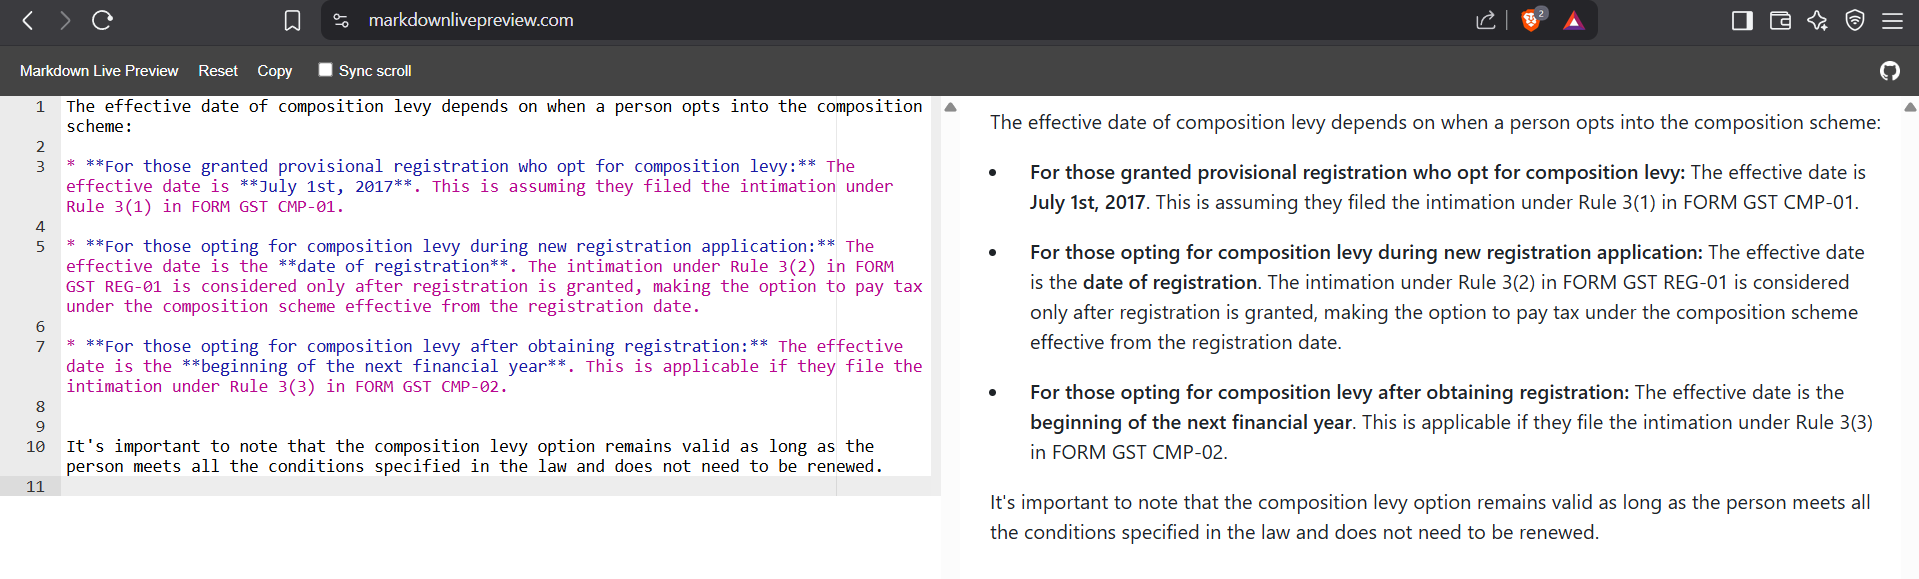